In [87]:
import numpy as np
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [88]:
BATCH_SIZE= 128
IMAGE_SIZE= (28,28,1,)
NUM_CLASSES= 10
LATENT_DIM= 2

In [89]:
def map_image(image, label):
    image= tf.cast(image, tf.float32)
    image= image/255.0
    image= tf.reshape(image, shape= (28, 28, 1))
    
    
    return image

def get_dataset(map_func):
    dataset= tfds.load('mnist', as_supervised= True, split= 'train')
    dataset= dataset.map(map_func)
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)
    
    return dataset

In [90]:
train_dataset= get_dataset(map_image)

In [91]:
builder = tfds.builder('mnist')
info = builder.info
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\ASUS TUF GAMING\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
 

In [92]:
class Sampling(tf.keras.layers.Layer): 
    def call(self, inputs):
        mu, sigma= inputs
        batch = tf.shape(mu)[0]
        dim= tf.shape(mu)[1]
        epsilon= tf.keras.backend.random_normal(shape=(batch, dim))
        
        return mu + tf.exp(0.5 * sigma) * epsilon

In [93]:
def encoder(inputs, latent_dim):
    x= layers.Conv2D(32, 3, 2, 'same', activation= 'relu', name= 'encoder_conv1')(inputs)
    x= layers.BatchNormalization(name= 'encoder_bn1')(x)
    x= layers.Conv2D(64, 3, 2, 'same', activation= 'relu', name= 'encoder_conv2')(x)
    
    batch_2 = layers.BatchNormalization(name= 'encoder_bn2')(x)
    
    x= layers.Flatten()(batch_2)
    x= layers.Dense(20, activation= 'relu', name= 'encoder_dense1')(x)
    x= layers.BatchNormalization(name= 'encoder_bn3')(x)
    
    mu= layers.Dense(latent_dim, name= 'latent_mu')(x)
    sigma= layers.Dense(latent_dim, name= 'latent_sigma')(x)
    
    return mu, sigma, batch_2.shape

In [94]:
def encoder_model(latent_dim, input_shape):
    inputs= layers.Input(shape= input_shape)
    mu, sigma, conv_shape= encoder(inputs, LATENT_DIM)
    z= Sampling()((mu, sigma))
    model= tf.keras.Model(inputs, outputs= [mu, sigma, z])
    
    return model, conv_shape

In [95]:
def decoder(inputs, conv_shape):
    units= conv_shape[1]*conv_shape[2]*conv_shape[3]
    x= layers.Dense(units, activation= 'relu', name= 'decoder_dense1')(inputs)
    x= layers.BatchNormalization(name= 'decoder_bn1')(x)
    x= layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name= 'decoder_reshape')(x)
    x= layers.Conv2DTranspose(64, 3, 2, 'same', activation= 'relu', name= 'decoder_conv1')(x)
    x= layers.BatchNormalization(name= 'decoder_bn2')(x)
    x= layers.Conv2DTranspose(32, 3, 2, 'same', activation= 'relu', name= 'decoder_conv2')(x)
    x= layers.BatchNormalization(name= 'decoder_bn3')(x)
    x= layers.Conv2DTranspose(1, 3, 1, 'same', activation= 'sigmoid', name= 'decoder_conv3')(x)
    
    return x

In [96]:
def decoder_model(latent_dim, conv_shape):
    inputs= layers.Input(shape=(latent_dim,))
    outputs= decoder(inputs, conv_shape)
    model= tf.keras.Model(inputs, outputs)
    
    return model

In [97]:
# custom loss kullback leibler divergence

def kl_loss(mu, sigma):
    kl_loss= 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    kl_loss= tf.reduce_mean(kl_loss)*-0.5
    
    return kl_loss

In [98]:
def vae_model(encoder, decoder, input_shape):
    inputs= layers.Input(shape= input_shape)
    mu, sigma, z= encoder(inputs)
    reconstructions= decoder(z)
    model= tf.keras.Model(inputs, reconstructions)
    
    loss= kl_loss(mu, sigma)
    model.add_loss(loss)
    
    return model

In [99]:
def get_models(input_shape, latent_dim):
    encoder, conv_shape= encoder_model(latent_dim, input_shape)
    decoder= decoder_model(latent_dim, conv_shape)
    vae= vae_model(encoder, decoder, input_shape)
    
    return encoder, decoder, vae

In [100]:
encoder, decoder, vae= get_models(IMAGE_SIZE, LATENT_DIM)

In [101]:
optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001)
loss_metric= tf.keras.metrics.Mean()
BCE_loss= tf.keras.losses.BinaryCrossentropy()

In [102]:
def generate_and_save_images(model, epoch, step, test_input):
  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

In [103]:
encoder.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder_conv1 (Conv2D)         (None, 14, 14, 32)   320         ['input_13[0][0]']               
                                                                                                  
 encoder_bn1 (BatchNormalizatio  (None, 14, 14, 32)  128         ['encoder_conv1[0][0]']          
 n)                                                                                               
                                                                                                  
 encoder_conv2 (Conv2D)         (None, 7, 7, 64)     18496       ['encoder_bn1[0][0]']     

1/1 [==============================] - 0s 27ms/step


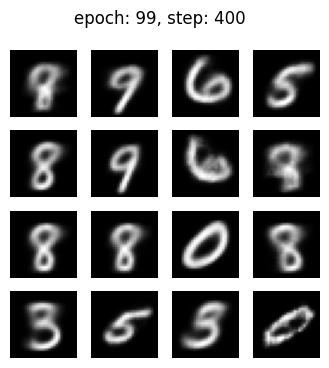

Epoch: 99 step: 400 mean loss = 145.1198


In [104]:
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

epochs = 100

generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:

      reconstructed = vae(x_batch_train)

      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = BCE_loss(flattened_inputs, flattened_outputs) * 784
      
      loss += sum(vae.losses)  

    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    loss_metric(loss)

    if step % 100 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))